# Ambient noise removel vignette

This vignette demonstrates step-by-step use of the ambient noise removel package to clean scRNA-seq data. 

## Preparation

First, let's import the Python packages we'll be using. If you don't have these installed, run `pip install XXX`

In [1]:
import sys

sys.path.append("../code")

from ambient_noise_py import *

%load_ext autoreload
%autoreload 2
pd.set_option("display.max_rows", 100)

During startup - Warning messages:
1: Setting LC_CTYPE failed, using "C" 
2: Setting LC_COLLATE failed, using "C" 
3: Setting LC_TIME failed, using "C" 
4: Setting LC_MESSAGES failed, using "C" 
5: Setting LC_MONETARY failed, using "C" 
6: Setting LC_PAPER failed, using "C" 
7: Setting LC_MEASUREMENT failed, using "C" 


## Loading the data

The ambient noise package is built around the [metacells](https://github.com/tanaylab/metacells/) framework. In particular it uses [anndata](https://pypi.org/project/anndata/) files generated and used by the metacells package to hold the analyzed data.

You can convert data from various "standard" scRNA data formats into a `.h5ad` file using any of the functions available in the scanpy and/or anndata packages. For full walkthrough about the different metacells files and the pipeline for generating those, go to the metacells github.

For the purposes of this vignette, we'll use scRNA human bone marrow cells from the [Hourigan paper](https://insight.jci.org/articles/view/124928) which contains tweenty individuals and tweenty five different batches. We will use an already processed version of the data, containing 87K cells, with several genes removed altoghter from the matrix and with a generated metacell model for those cells.

In [2]:
data_path = "/home/drorba/raid/ambient/data/bm"
output_path = "/home/drorba/raid/ambient/out/bm"

mat_clean_path = "/home/drorba/raid/ambient/data/bm/mcs/cells.h5ad"
metacells_path = "/home/drorba/raid/ambient/data/bm/mcs/metacells.h5ad"

In [3]:
mat_ad = get_cells_mat(mat_clean_path)
metacells_ad = ad.read_h5ad(metacells_path)

### Loading empty droplets information

The ambient noise package uses the raw [cellranger count](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/count) output to estimate the distribution of noisy genes. This is being done by aggrigating the empty droplets (cells with less then specific number of RNA molecules, default is 100).

To get this information, one should provide a mapping between each batch and the raw cellranger output. The pipelines then read each file and summaries it's information, which require from the user to specify a function able to read the cellranger files. In this specific case we will use the scanpy function: read_10x_h5

Although this process is being run in parallel, it is suggested to save the summed up data to save time. We commented out the actual lines which generate the empty droplets information and will upload the save version instead.

In [4]:
raw_input_folder = os.path.join(data_path, "GSE120221_cellranger_output")
batches = [
    "A",
    "B",
    "C1",
    "Ck",
    "C2",
    "E",
    "F",
    "G",
    "H",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S1",
    "Sk1",
    "S2",
    "Sk2",
    "T",
    "U",
    "W",
]
batches_to_mtx_paths = {
    batch: os.path.join(raw_input_folder, batch, "outs/raw_feature_bc_matrix.h5")
    for batch in batches
}

# batch_empty_droplets = get_empty_droplets_information(batches_to_mtx_paths, read_file_func=sc.read_10x_h5)
# with open(os.path.join(output_path,"batch_empty_droplets_dict.pkl"), "wb") as f:
#     pickle.dump(batch_empty_droplets, f)

with open(os.path.join(output_path, "batch_empty_droplets_dict.pkl"), "rb") as f:
    batch_empty_droplets = pickle.load(f)

### Preparing files for pipeline

We want to make sure that the cells, metacells and empty droplets information all have the same genes to calculate the noise estimation correctly.

After that we want to add the batches names for each cell in the cell matrix. Those batch names should match the ones specific in the batches to cellranger mapping.

In [5]:
# dataset specific functions
def add_batches_names(mat_clean):
    batches_name = [i[1] for i in mat_clean.obs.batch.str.split(".")]
    mat_clean.obs["batch"] = batches_name
    return mat_clean

In [6]:
mat_ad, metacells_ad, batch_empty_droplets = filter_on_common_genes(
    mat_ad, metacells_ad, batch_empty_droplets
)

mat_clean_df = mc.ut.get_vo_frame(mat_ad)
metacell_df = mc.ut.get_vo_frame(metacells_ad)

mat_ad = add_batches_names(mat_ad)

Trying to set attribute `.obs` of view, copying.


## Identifying noise prone features using two-way clustering

The ambient noise package work in three different levels: the first one is based on umis count, the second is clusters of metacells and highly differential genes and the third level is batch specific.

The noise estimation is beeing calculated for each umis count bin individually, using all the possible metacells and genes clusters. 

### Umis count bins

The first step require the user to specify the number of umi counts bins we want to split the data into. The pipeline split the cells based on percentile after removing the bottom and top 5 percentiles (can be modified in the function `get_umi_count_threshold_list`). 

In [7]:
num_bins = 3
cells_total_umis_count = pd.Series(
    data=mc.ut.get_o_numpy(mat_ad, name="__x__", sum=True), index=mat_clean_df.index
)
mat_ad.obs["umi_depth"] = cells_total_umis_count
bins_threshold_list = get_umi_count_threshold_list(cells_total_umis_count, num_bins)

### Metacells and genes clusters

We are going to perform a two-way clustering process of metacells and top differential genes. 
The clustering process will suggest genes clusters or metacells clusters to remove from the pipeline based on number of genes\metacells they include.

We will then generate plots to view this clustering results, once you feel happy with this process you can move to the next step.

In [8]:
top_diff_genes = get_top_diff_genes(metacell_df, genes_min_diff=4)
genes_clusters, mc_clusters = cluster_genes_and_mc(
    metacell_df,
    genes_to_use=top_diff_genes,
    num_of_genes_cluster=10,
    number_of_mc_clusters=10,
)
mat_ad = annotate_based_on_df(mat_ad, mc_clusters)
empty_droplet_gcluster_fraction = get_empty_droplet_gcluster_fraction(
    batch_empty_droplets, genes_clusters
)

Gene cluster: g4 has only 1 gene(['IFI27']), suggest to filter it out
forbidden_gclusters=['g4']


<Figure size 432x288 with 0 Axes>

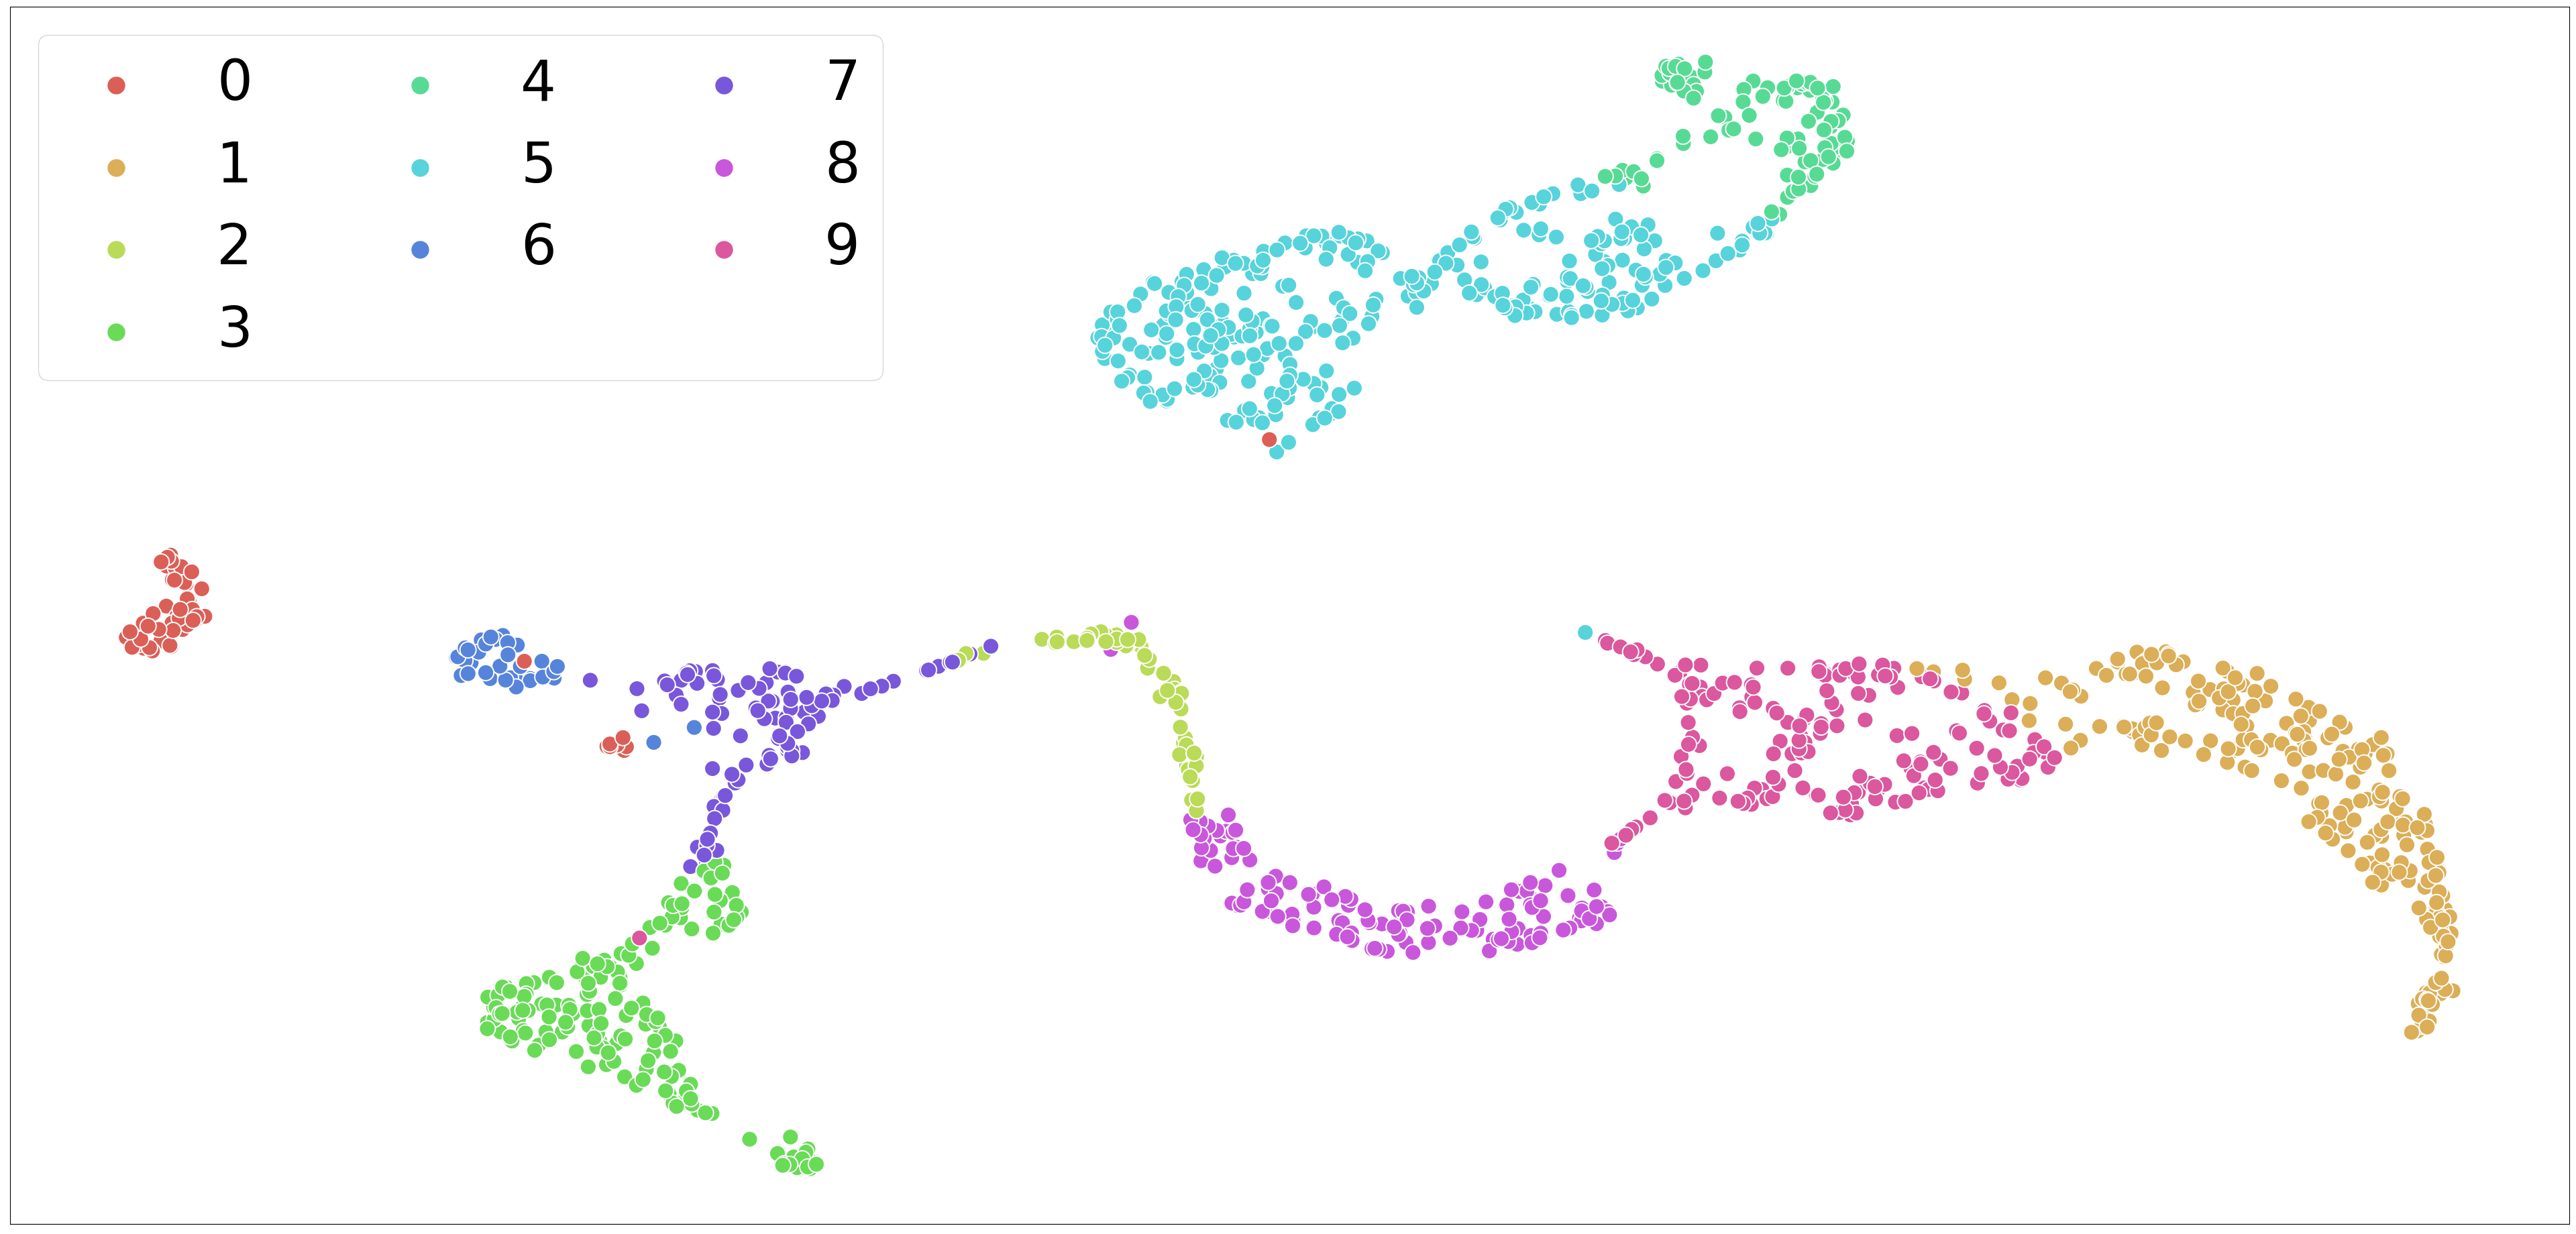

<Figure size 640x480 with 0 Axes>

<Figure size 20000x10000 with 0 Axes>

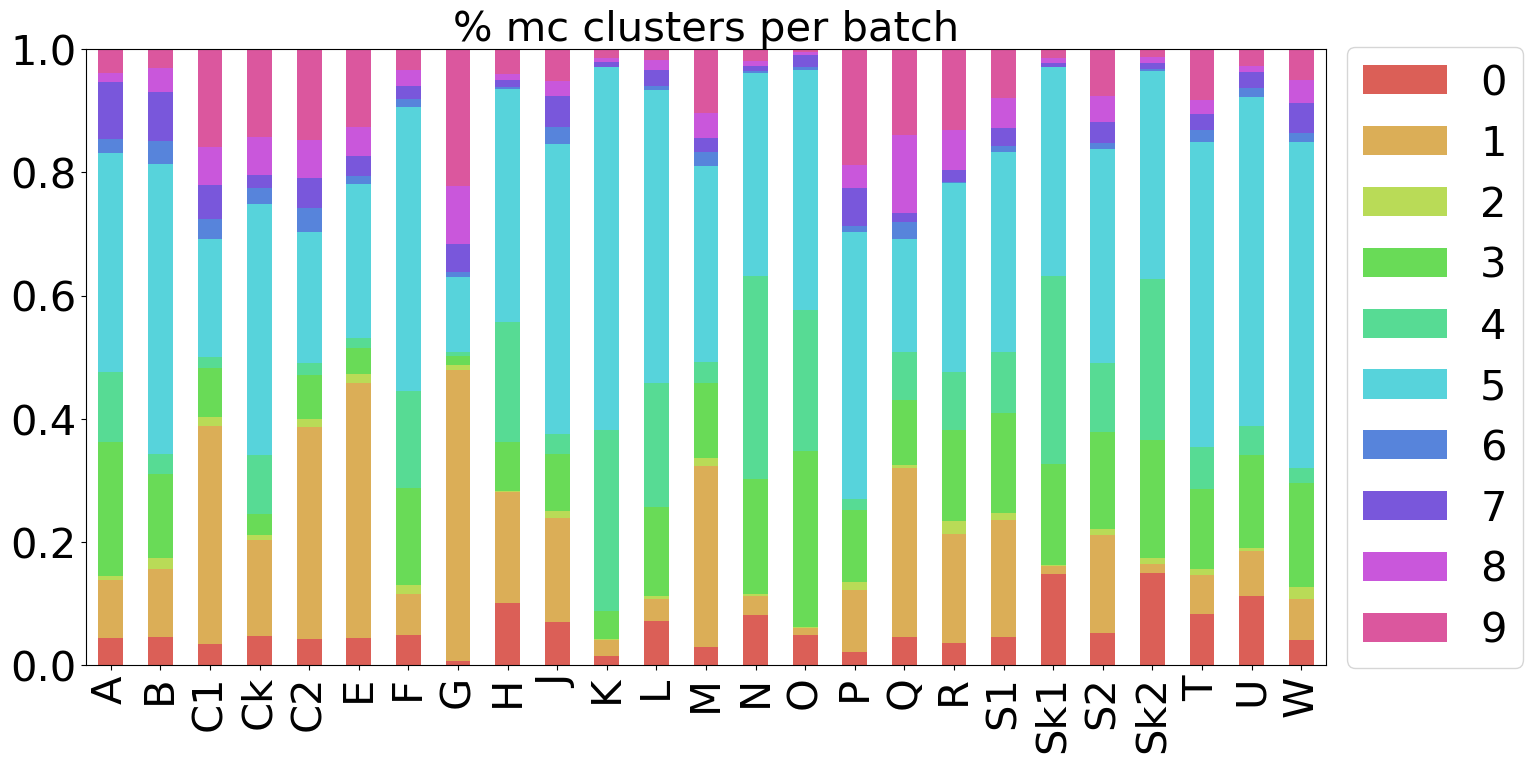

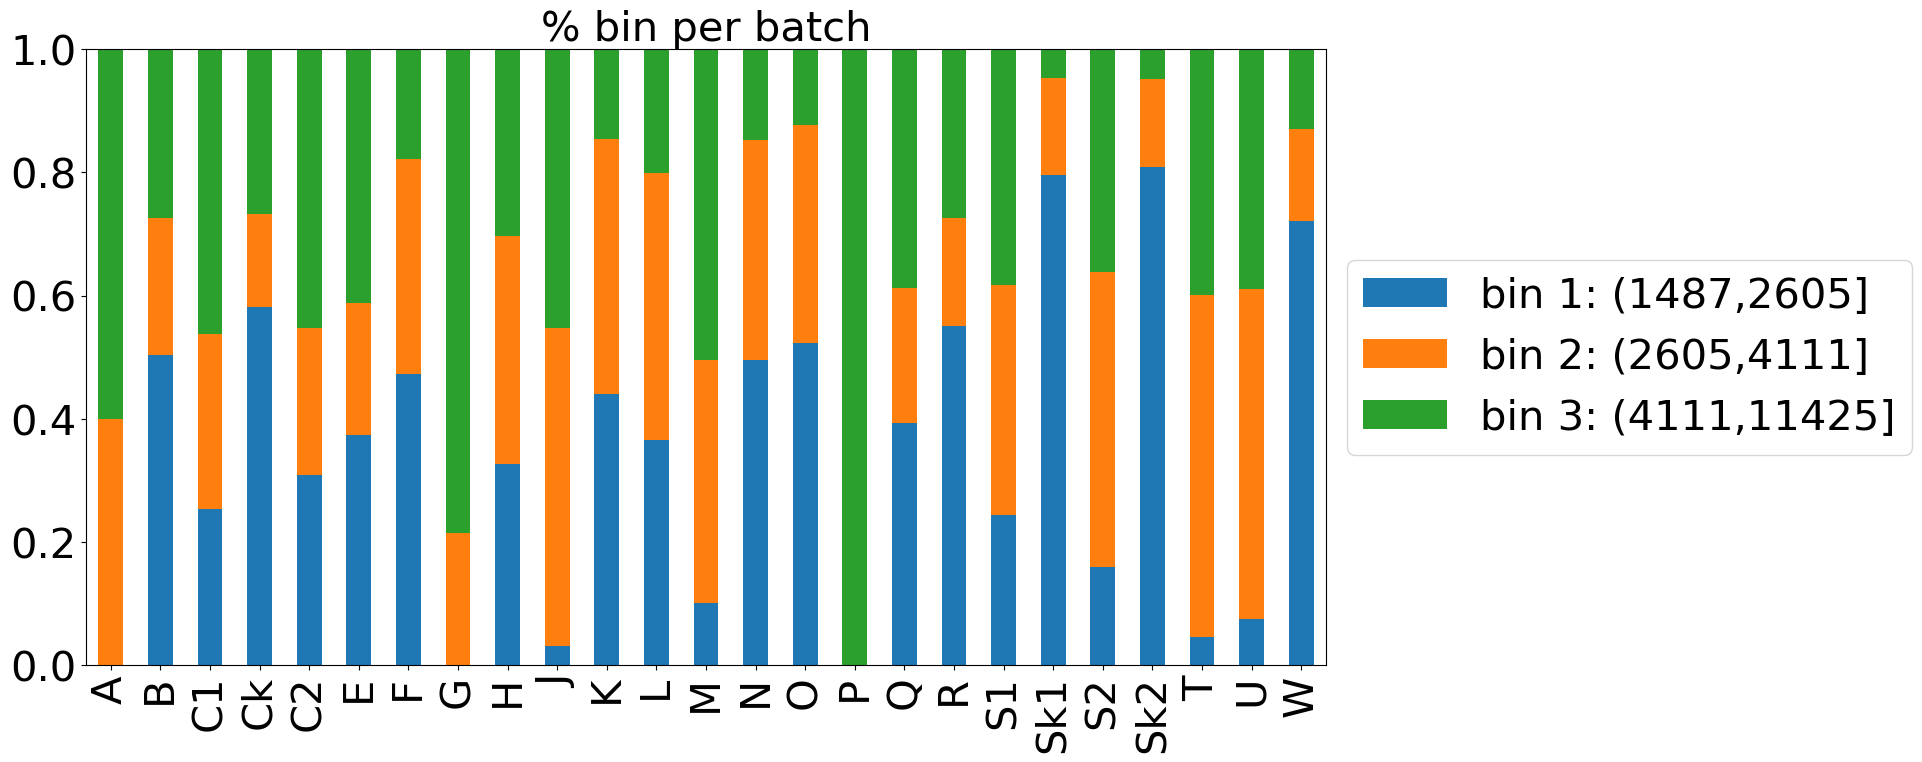

<Figure size 640x480 with 0 Axes>

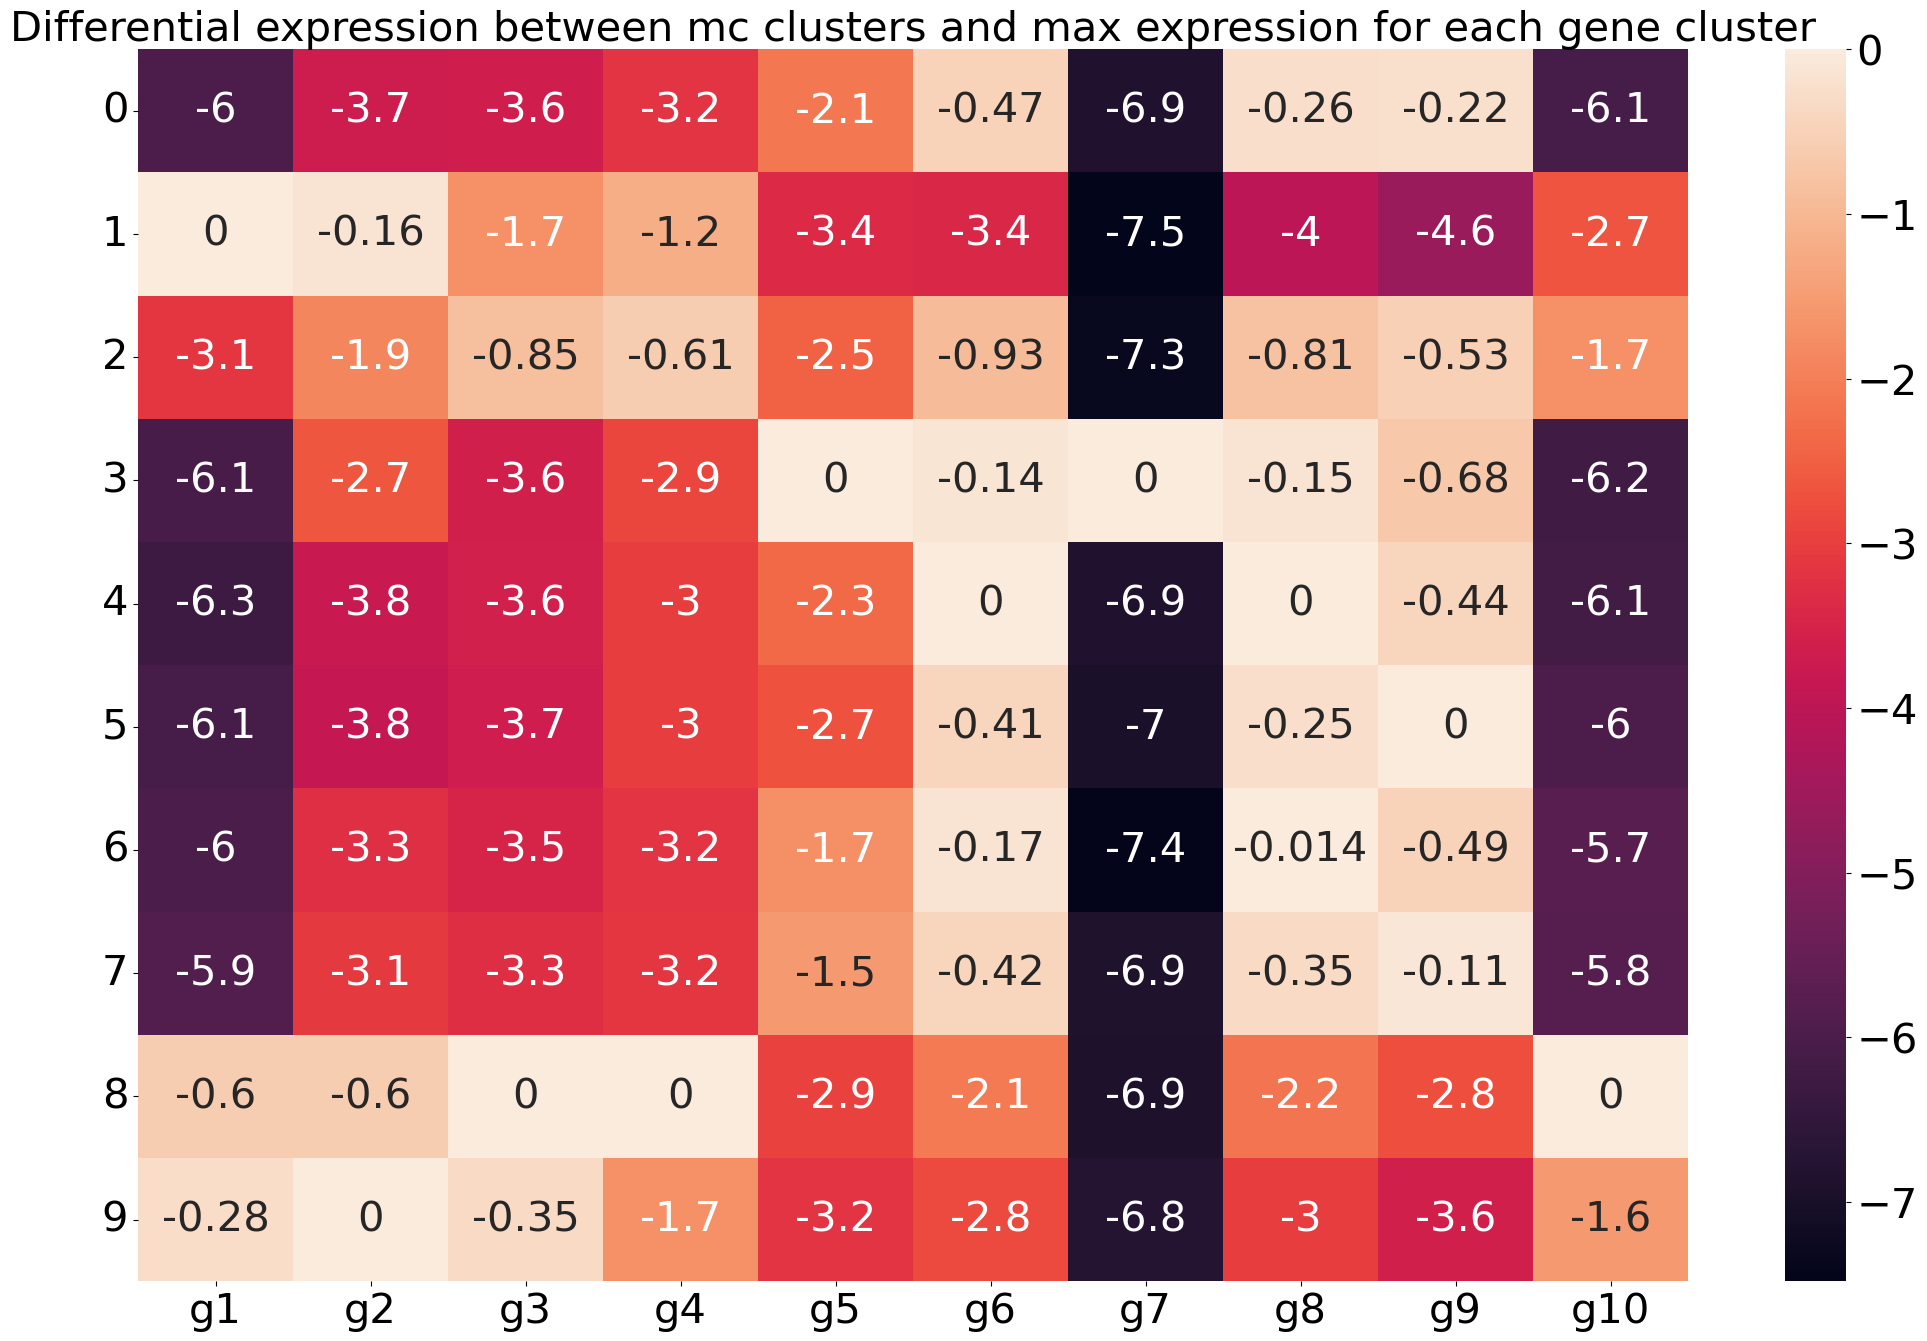

In [12]:
# plot clustering to make sure we are ok with it
plot_annotation_on_umap(metacells_ad, mc_clusters)
plot_genes_mc_clusters(genes_clusters, mc_clusters, metacell_df)
plot_clusters_bins_distribution(mat_ad, batches, num_bins, bins_threshold_list)
plot_expression_diff_between_clusters(genes_clusters, mc_clusters, metacell_df)

## Estimation of batch specific ambient noise levels  

The estimation process is the heart of the ambient noise package. 

This process assumes genes cluster which drastically expressed very little in a metacell cluster is mostly being generated by noise. This allow us to take those metacells-genes combination and try to deconvolve the observed umis to two parts: umis which generated from noise and umis which generated from native true expression of this gene module in those metacells  (named `Egt - Expressed Genes in Type`). 
The key point is that different different pairs of metacells and genes clusters should have the same noise estimation if they share the same batch, while the same pair of metacell and gene cluster should have the same Egt even between batches.

The pipeline add more and more paris of metacells and genes and try to estimate both the noise and Egt fraction simultaneously. This allows the user to view and choose the threshold most suited for the data provided. 
It is important to notice that we ignore metacells-genes couple which don't have enough umis in them, or those which appear in only few number of batches. We also ignore batches without enough metacells-genes pairs. All those thresholds can be changed in the funciton `calculate_alpha_egt` (using those three parameters: `min_expected_umi_threshold`, `min_number_of_gmctypes_per_batch`, `min_number_of_batches_per_gmctypes`)

At the beginning of the process, each umi count bins is being handle on it's own, and the Egt is bin specific.

In [13]:
egt_per_bin_df_dict, threshold_to_egt_dict = get_egt_per_threshold(
    genes_clusters,
    mc_clusters,
    empty_droplet_gcluster_fraction,
    num_bins,
    mat_clean_df,
    mat_ad,
    metacell_df,
    bins_threshold_list,
    thr_max_value=-2,
    forbidden_gclusters=["g4"],
)
calculation_results, batches_egt_tracker = calculate_alpha_egt(
    egt_per_bin_df_dict, threshold_to_egt_dict, batches, num_bins
)

Fitting over different thresholds for bin: 3: 100%|██████████| 61/61 [00:43<00:00,  1.41it/s]


<Figure size 432x288 with 0 Axes>

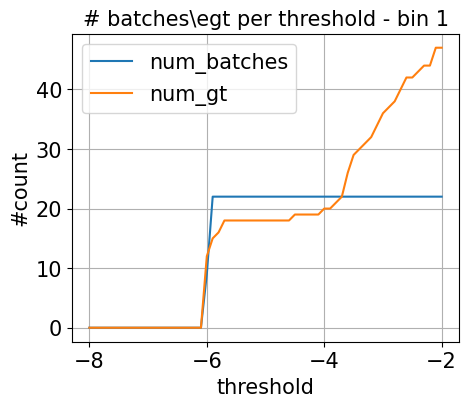

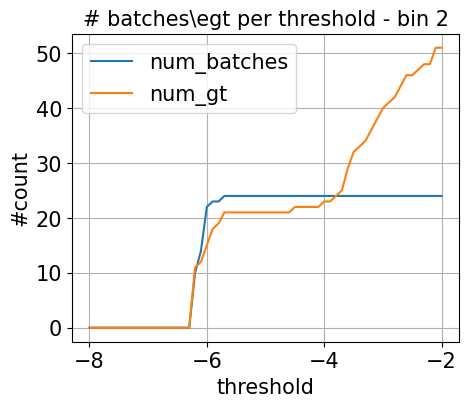

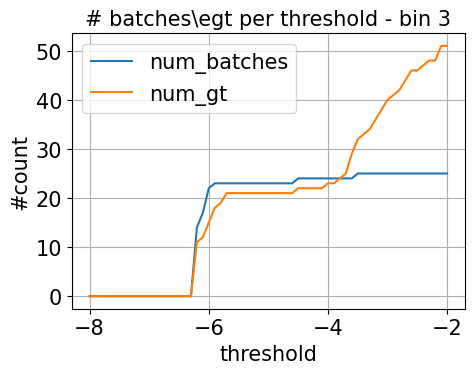

<Figure size 640x480 with 0 Axes>

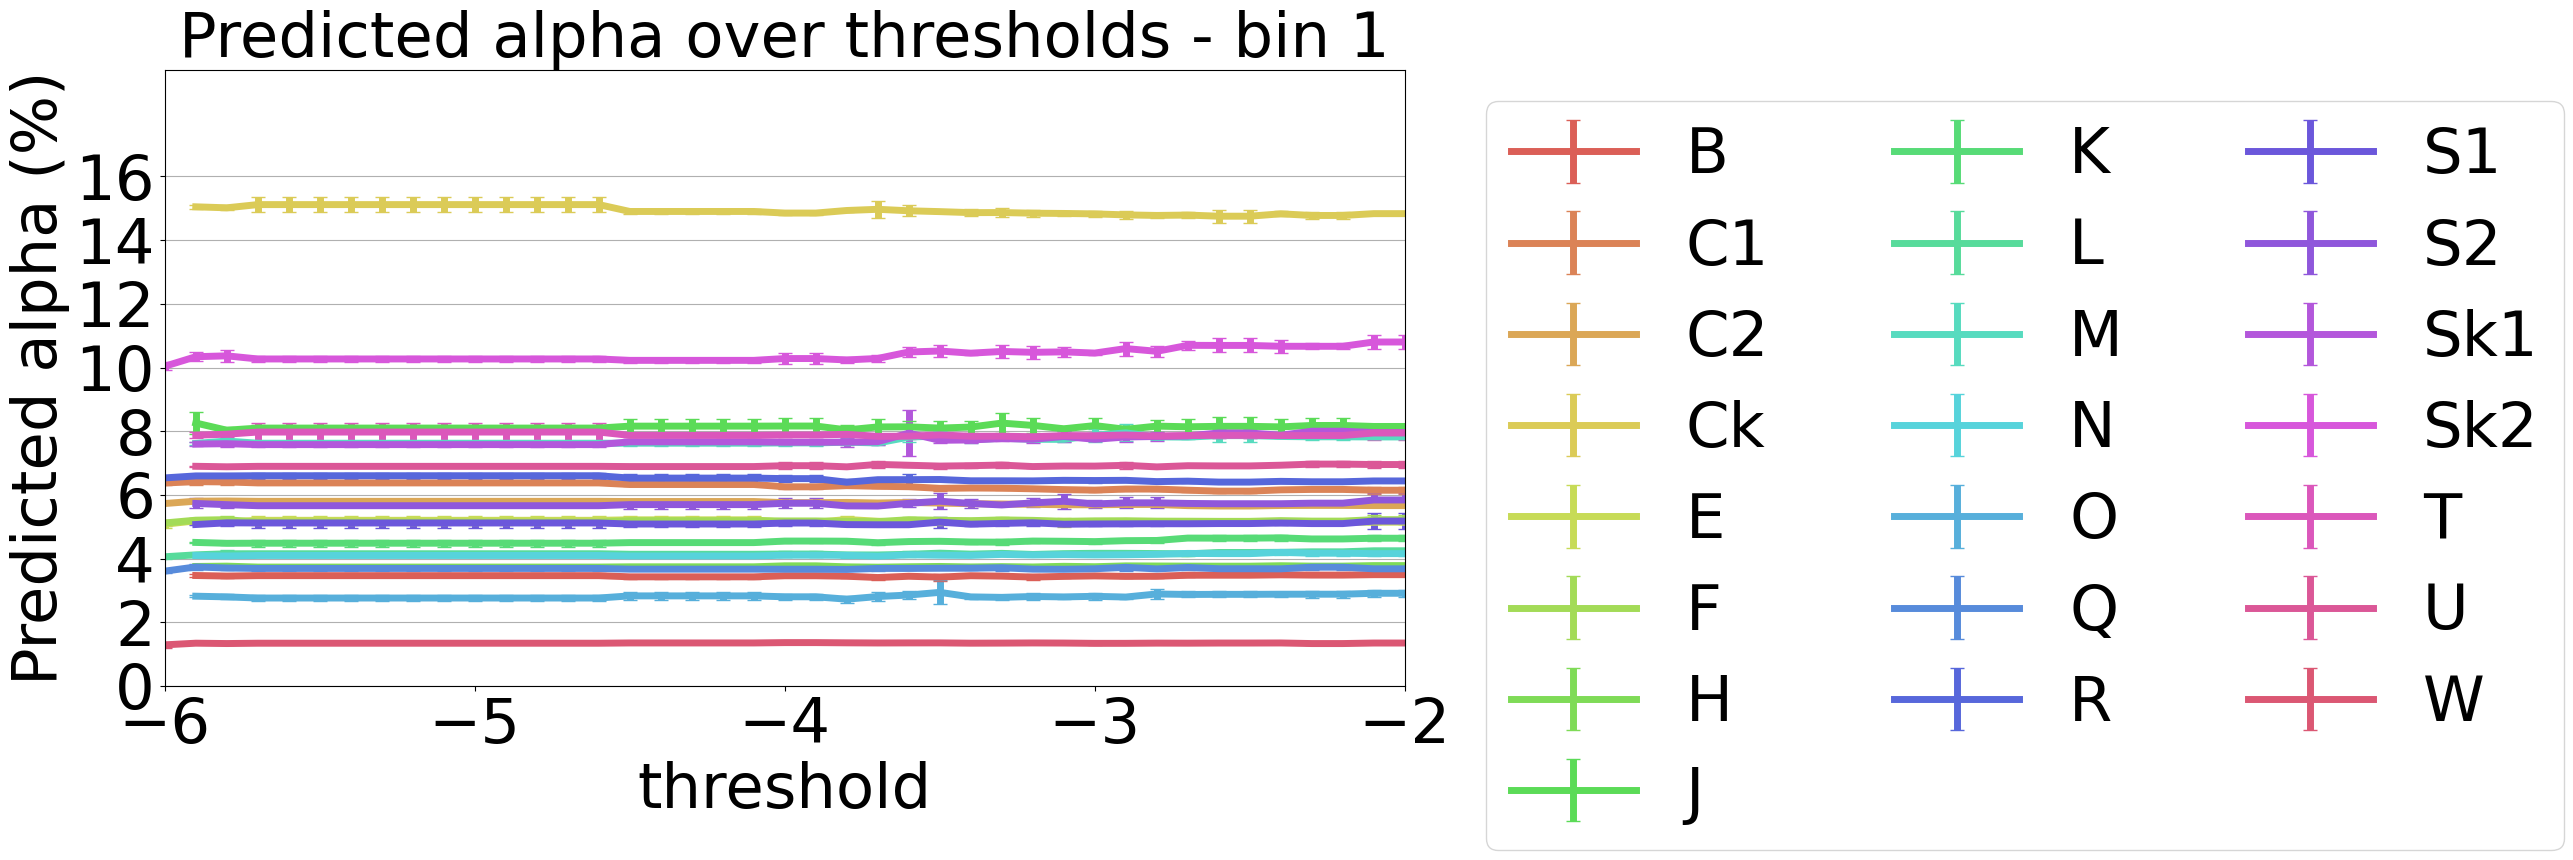

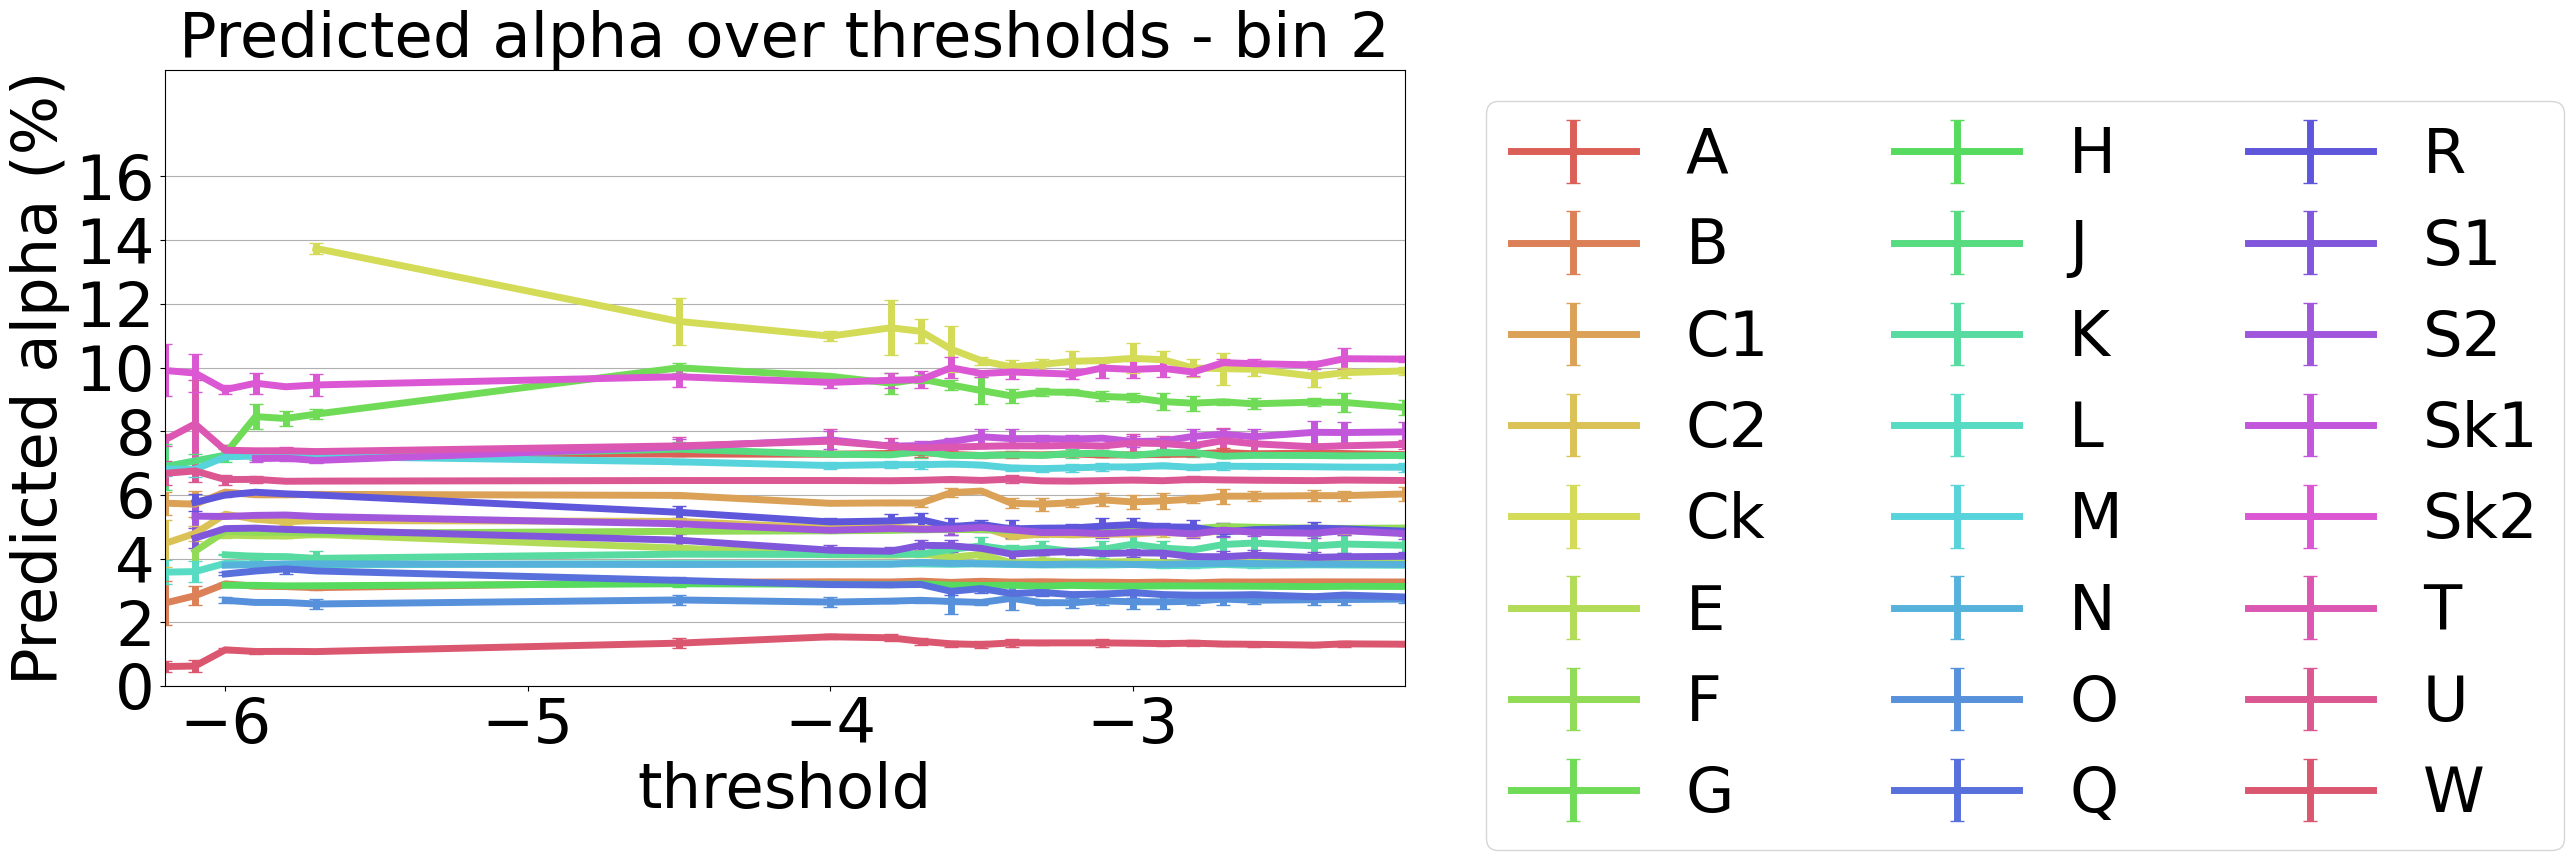

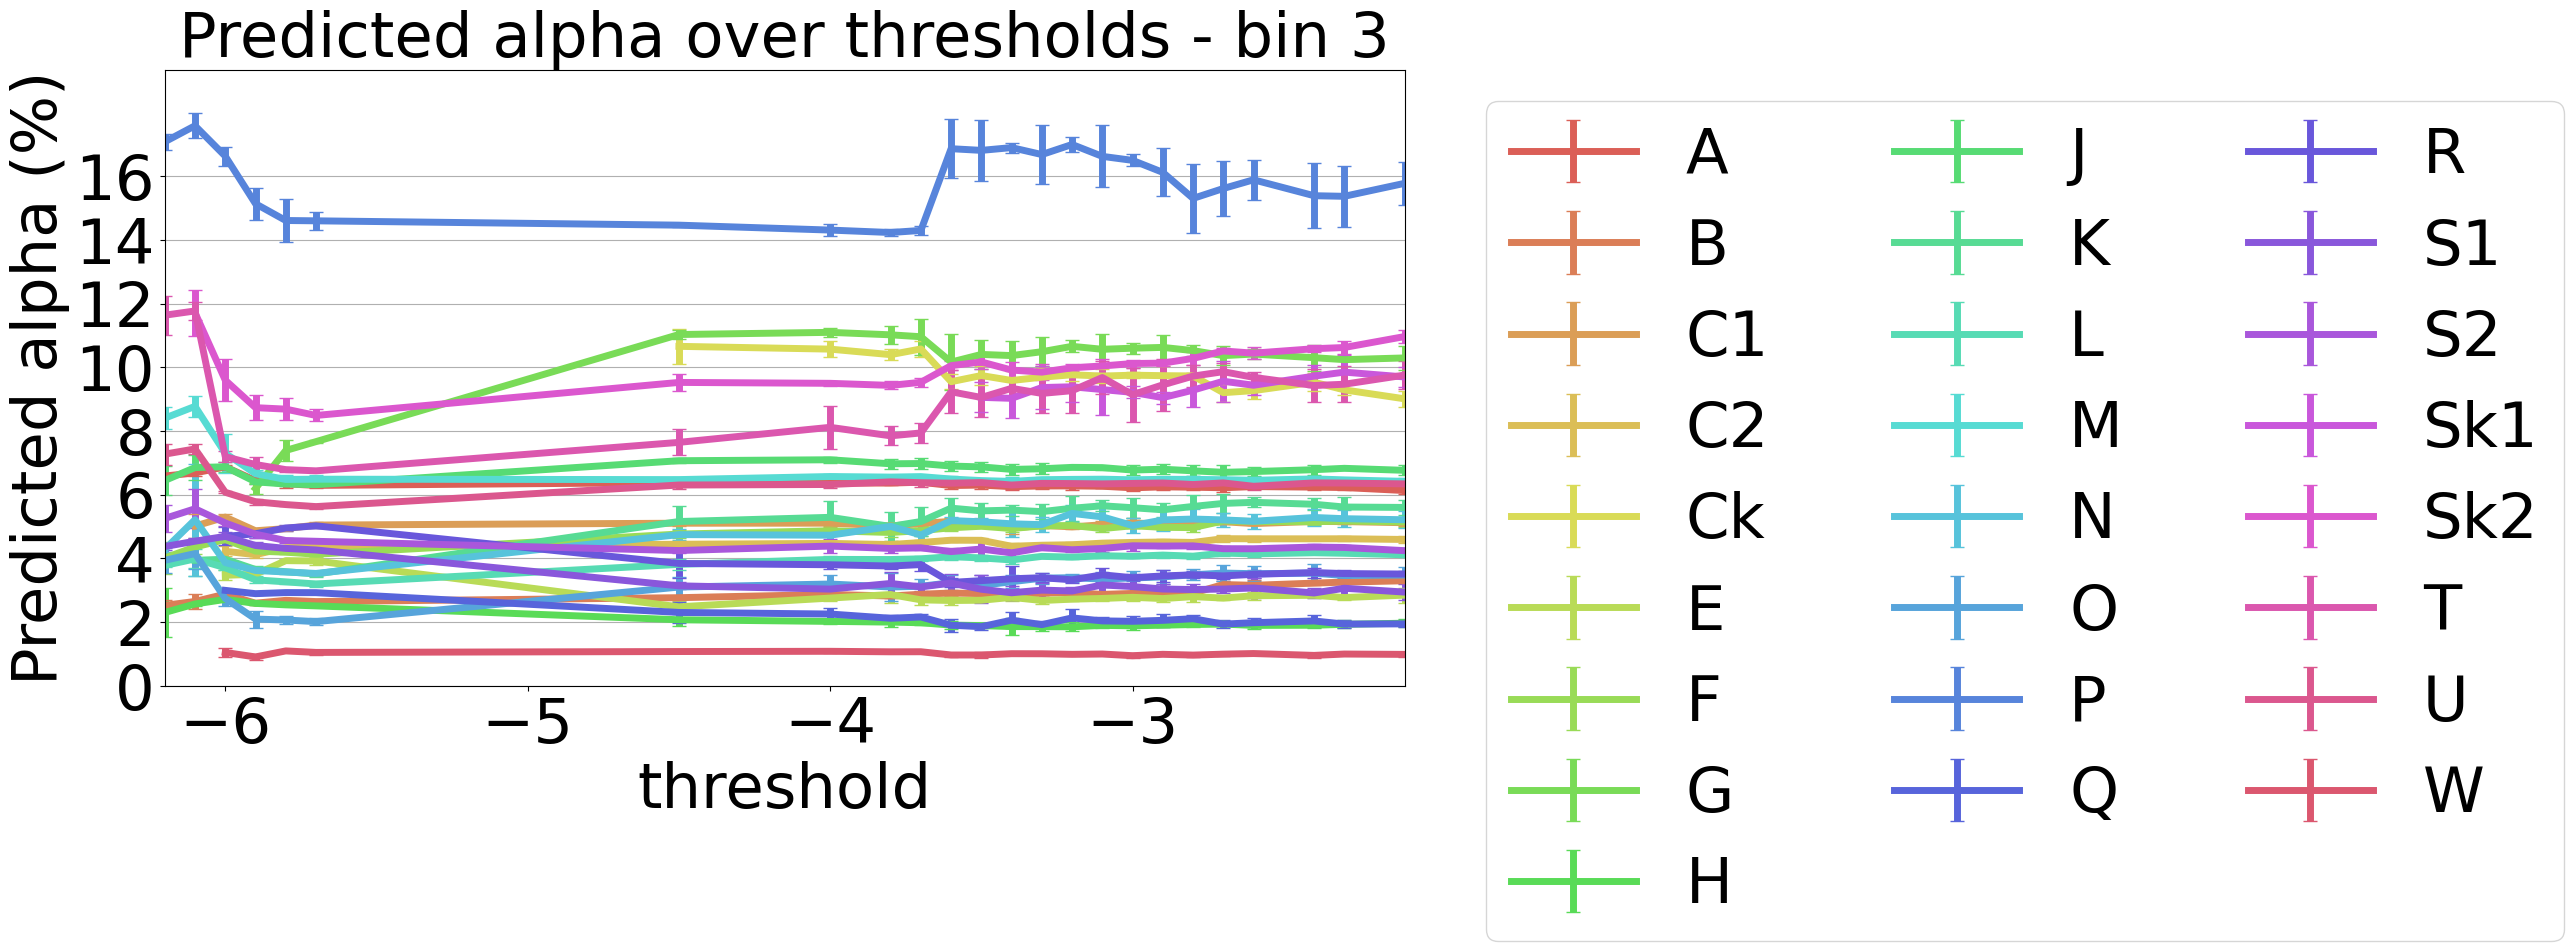

<Figure size 640x480 with 0 Axes>

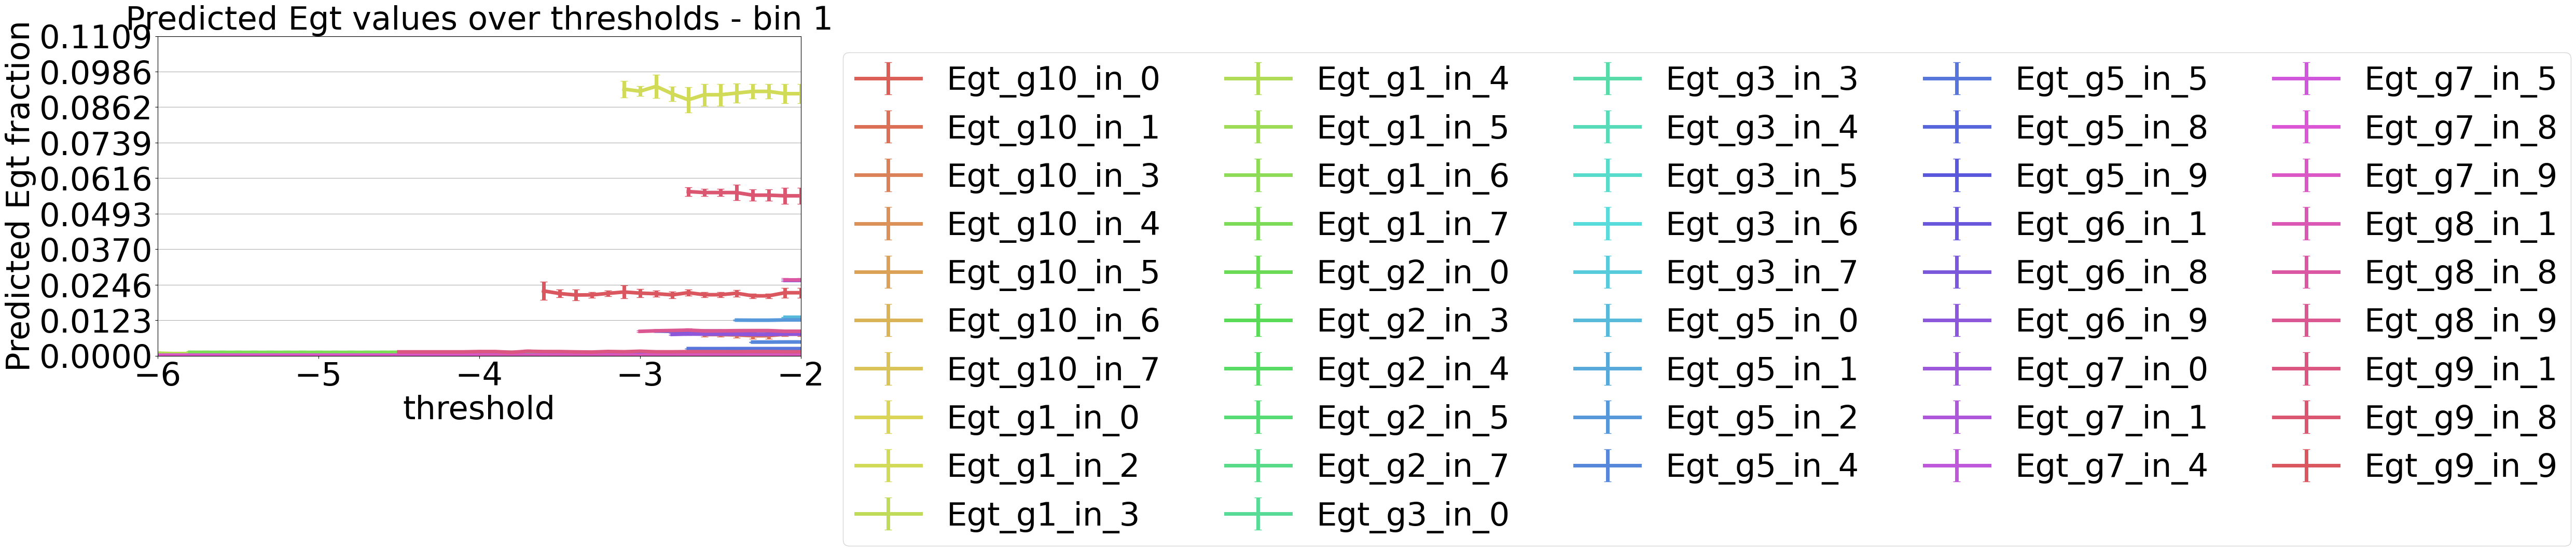

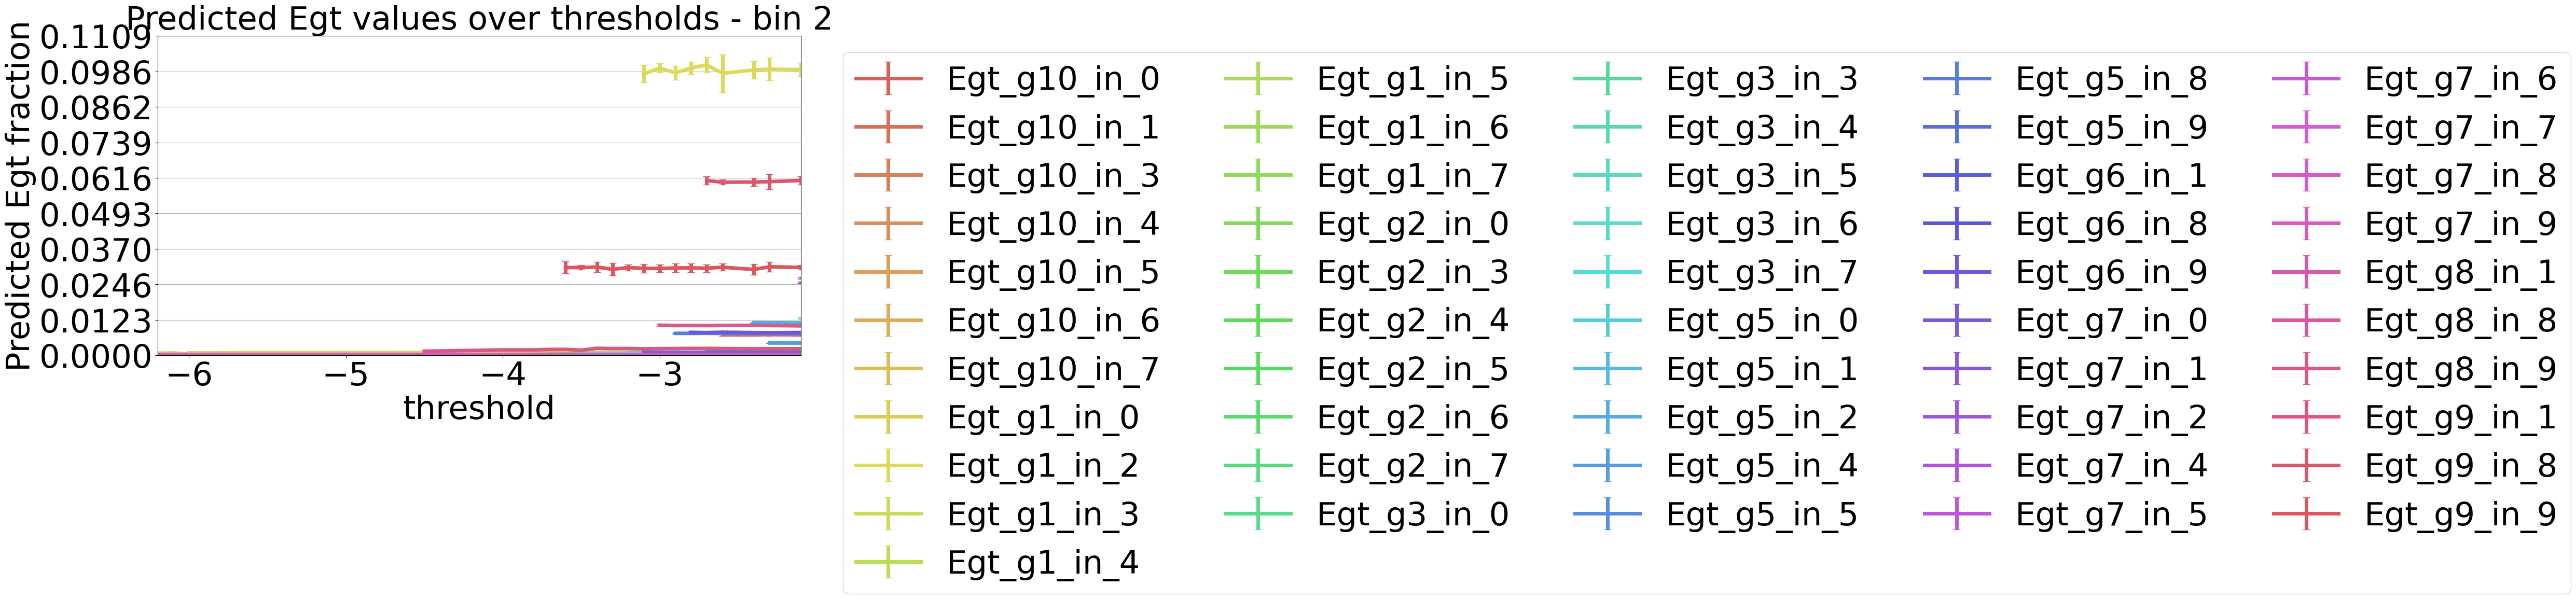

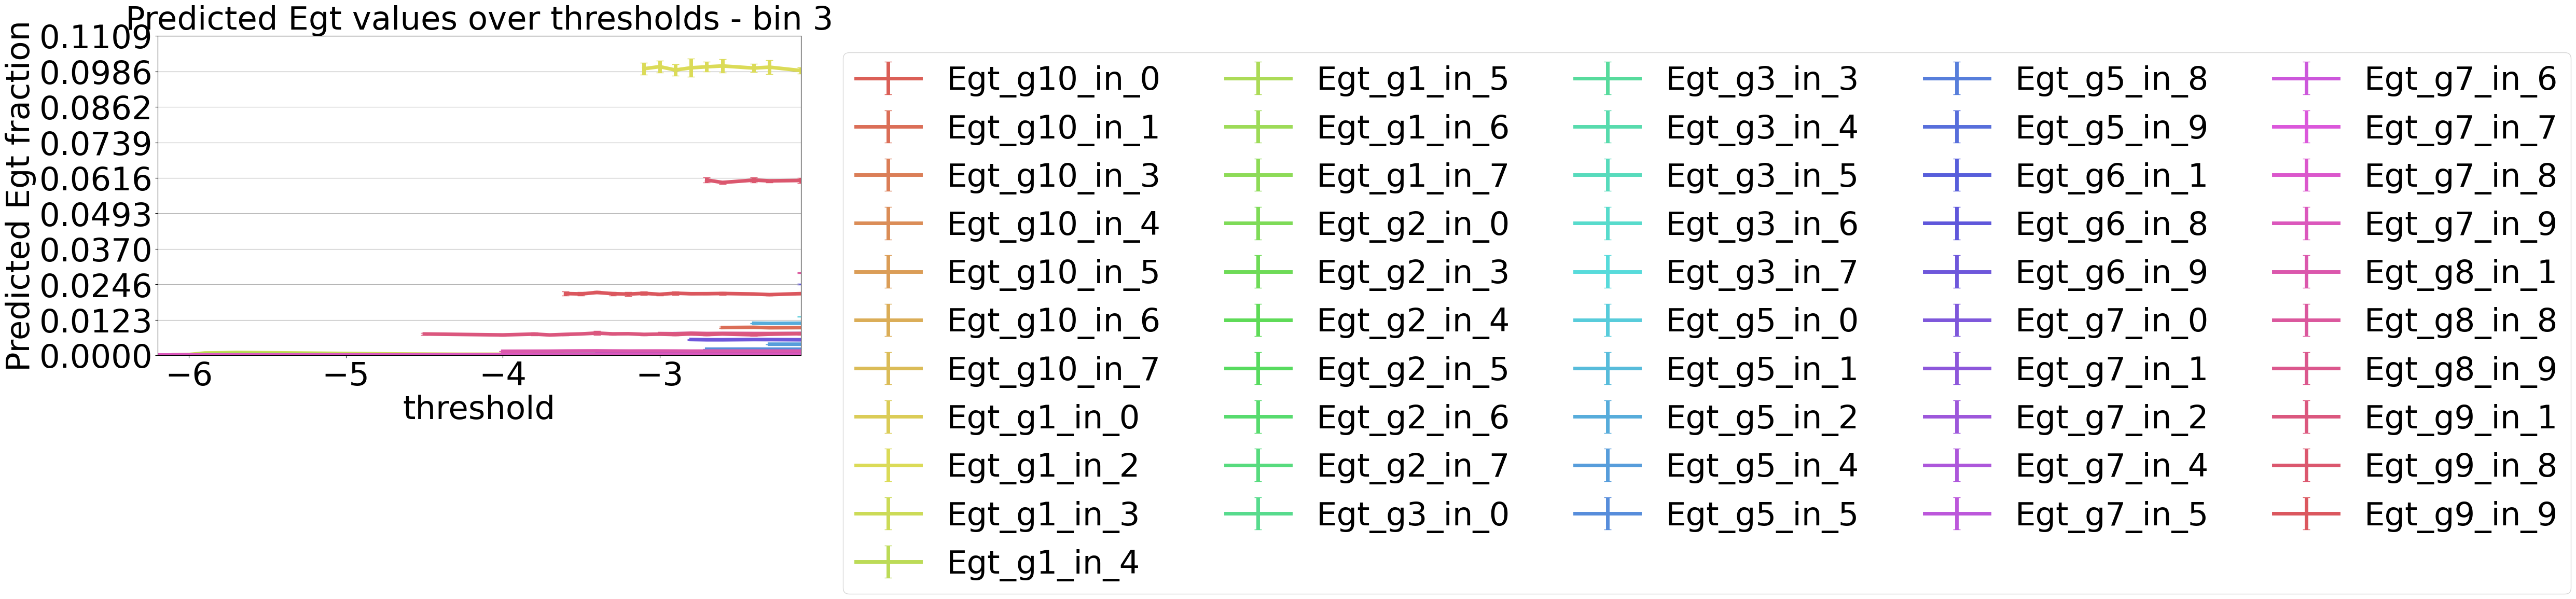

In [15]:
# plot results
plot_batch_egt_tracker(batches_egt_tracker)
plot_noise_egt_estimation_over_thresholds(calculation_results)

### Choosing the threshold 

After looking at the plots we want to choose a threshold for metacell-genes clusters. 

In general we want to choose a threshold which allow estimation for all batches. It is better to choose one thich most of its Egt is 0 or close to it, which means that indeed most of the umis we see was generated by noise.

We will plot several graphs to see the difference in Egt between umis count bins for this specific threshold. The logic here is that there shouldn't be any difference between those, as this represent an inherit property of the metacell type. 
Using this information we will re-run the noise estimation process, but now we will share the Egt between different umis bins - while still allowing diffrent noise estimation for those umis bins 

In [21]:
threshold = -4

<Figure size 640x480 with 0 Axes>

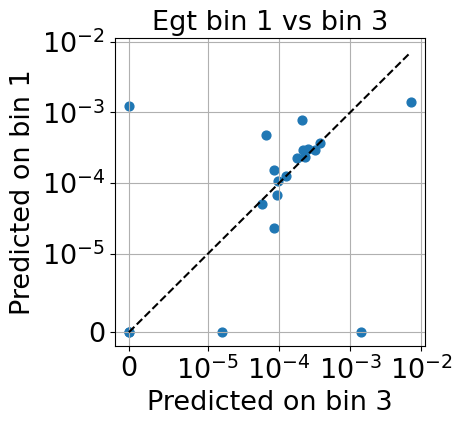

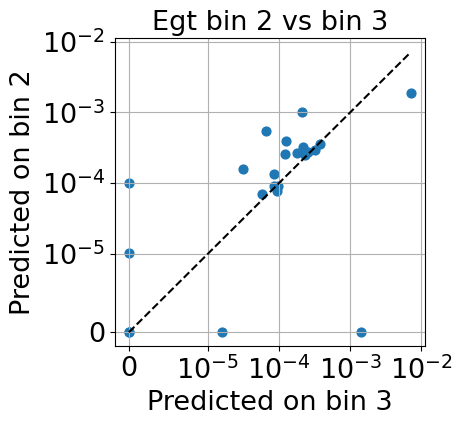

<Figure size 640x480 with 0 Axes>

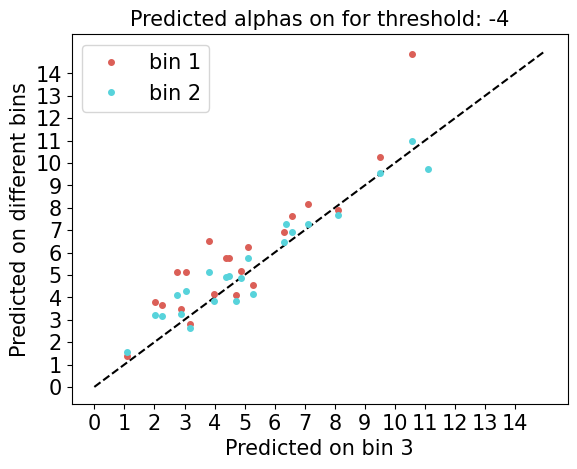

<Figure size 640x480 with 0 Axes>

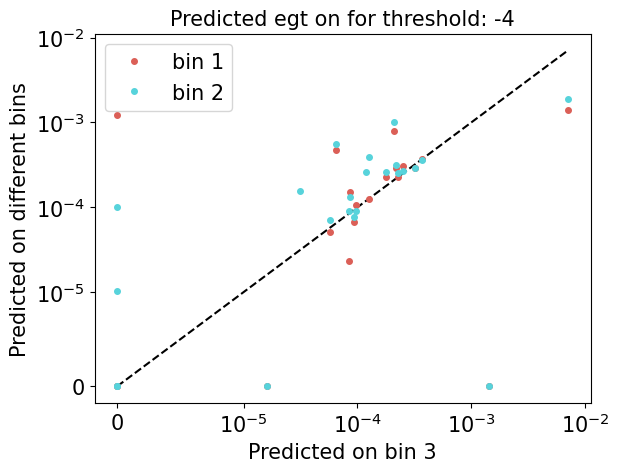

In [22]:
plot_egt_comparison_on_single_threshold(
    calculation_results, threshold=threshold, scale=1.3
)
plot_batch_egt_results_on_single_plot(calculation_results, threshold=threshold, scale=1)

In [25]:
valid_ctypes_for_combined_calculation = get_shared_ctypes(
    calculation_results, threshold_to_egt_dict, threshold=threshold
)
glm_combined_results, equations = calculate_alpha_egt_with_shared_egt(
    egt_per_bin_df_dict,
    valid_ctypes_for_combined_calculation,
    batches,
    min_number_of_gmctypes_per_batch=10,
    min_number_of_batches_per_gmctypes=5,
    get_equations=True,
)
batches_prediction, egt_prediction = split_results_to_batches_egt(glm_combined_results)

We can plot the results of the estimation per umis counts, and check the estimation change pre and post the Egt sharing process.

Another important thing is to make sure that the estimation is in a global minima, to do this we will also add a log likelihood plot which can help a user decide to take a slightly bigger or smaller noise estimation for a specific batch

<Figure size 432x288 with 0 Axes>

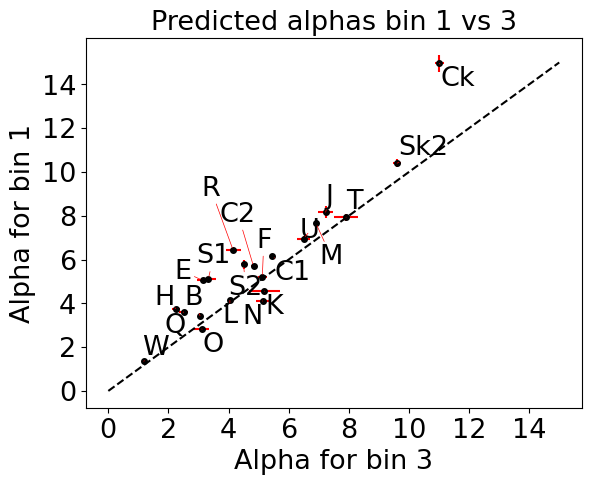

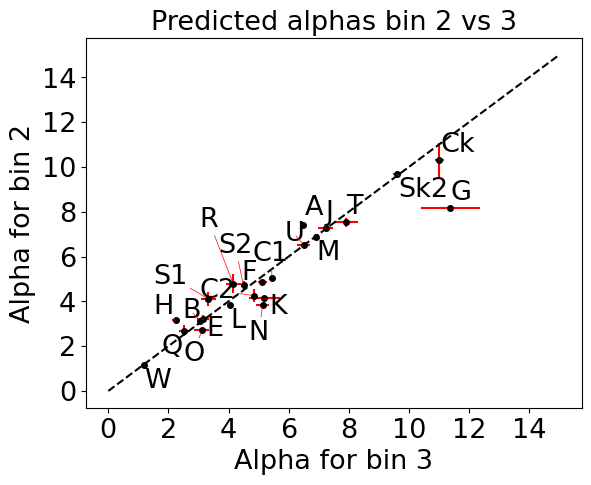

<Figure size 640x480 with 0 Axes>

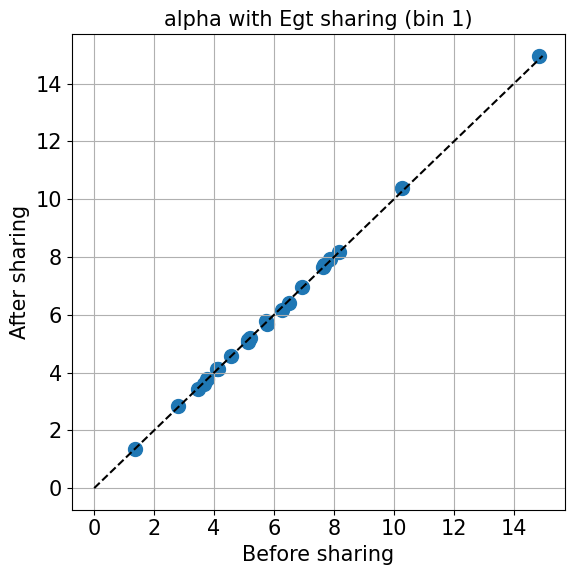

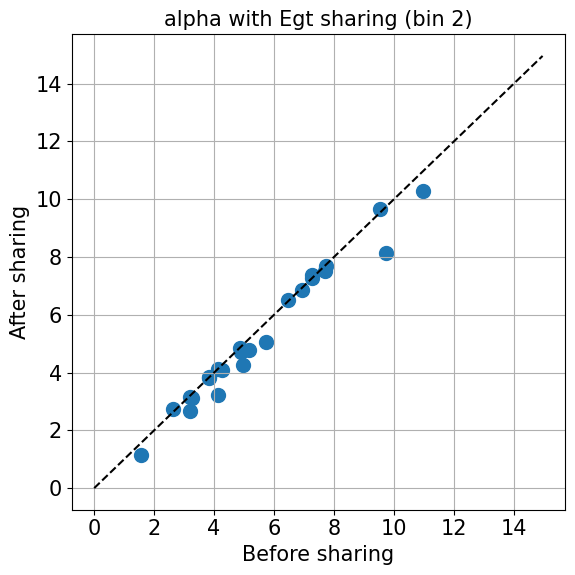

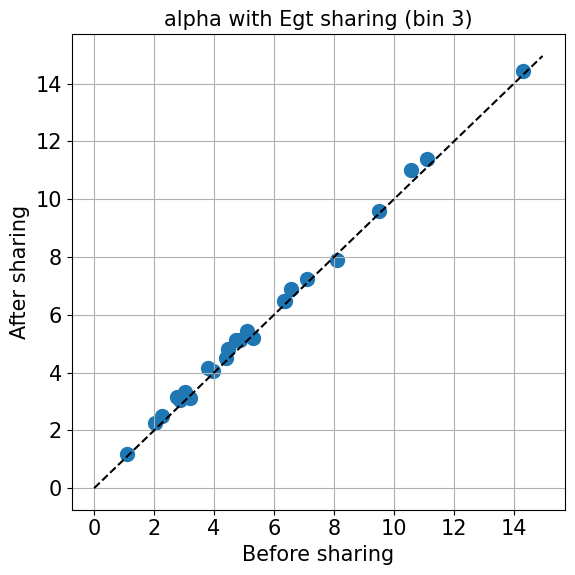

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

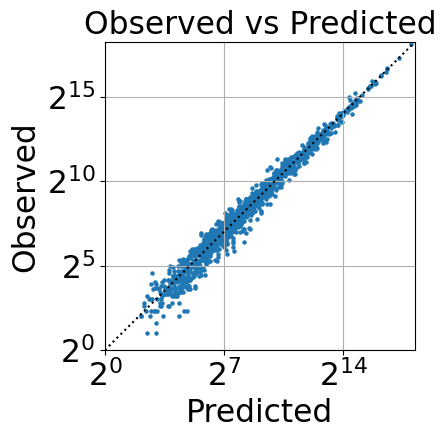

In [34]:
plot_batches_predictions_across_bins(
    batches_prediction, show_txt=True, show_err=True, font_scale=1.3
)
plot_alphas_predictions_before_after_egt_share(
    calculation_results, glm_combined_results, threshold=threshold, scale=1
)
plot_ll_of_prediction(equations, glm_combined_results, max_alpha=0.2, ncols=6)
plot_predicted_vs_observed(equations, glm_combined_results)

If needed, you can plot which Egt were used for each batch. This might help identify pairs of metacells-genes clusters which you should remove from the process.

<Figure size 640x480 with 0 Axes>

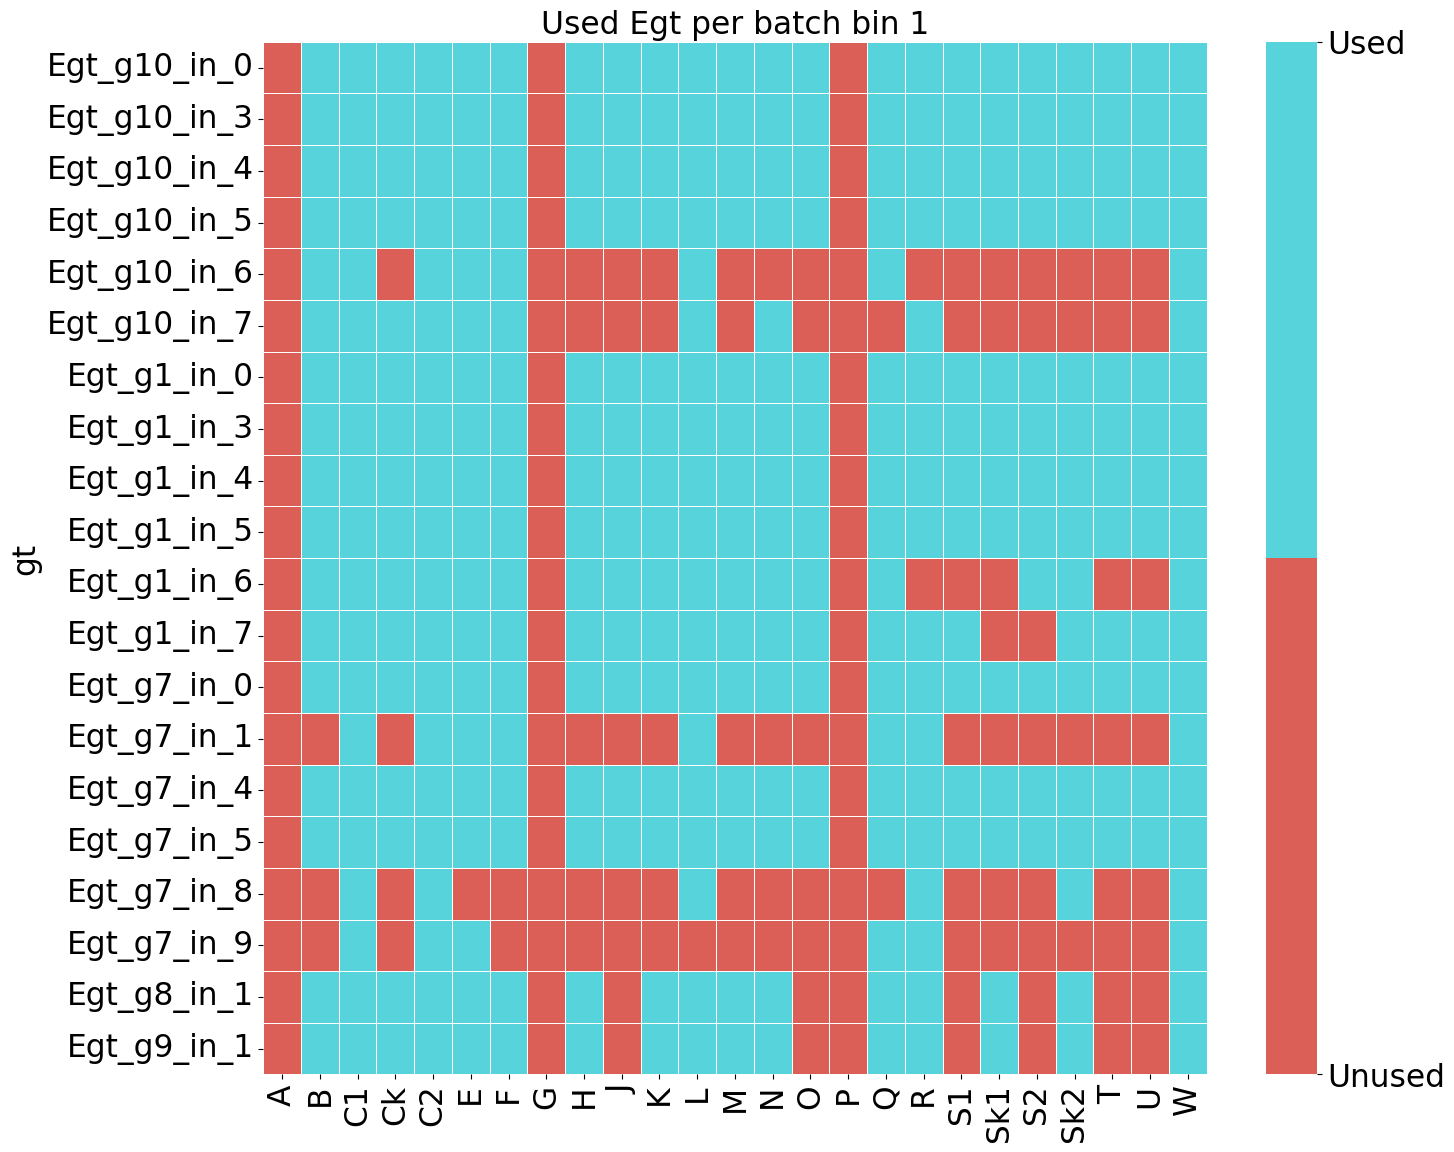

<Figure size 640x480 with 0 Axes>

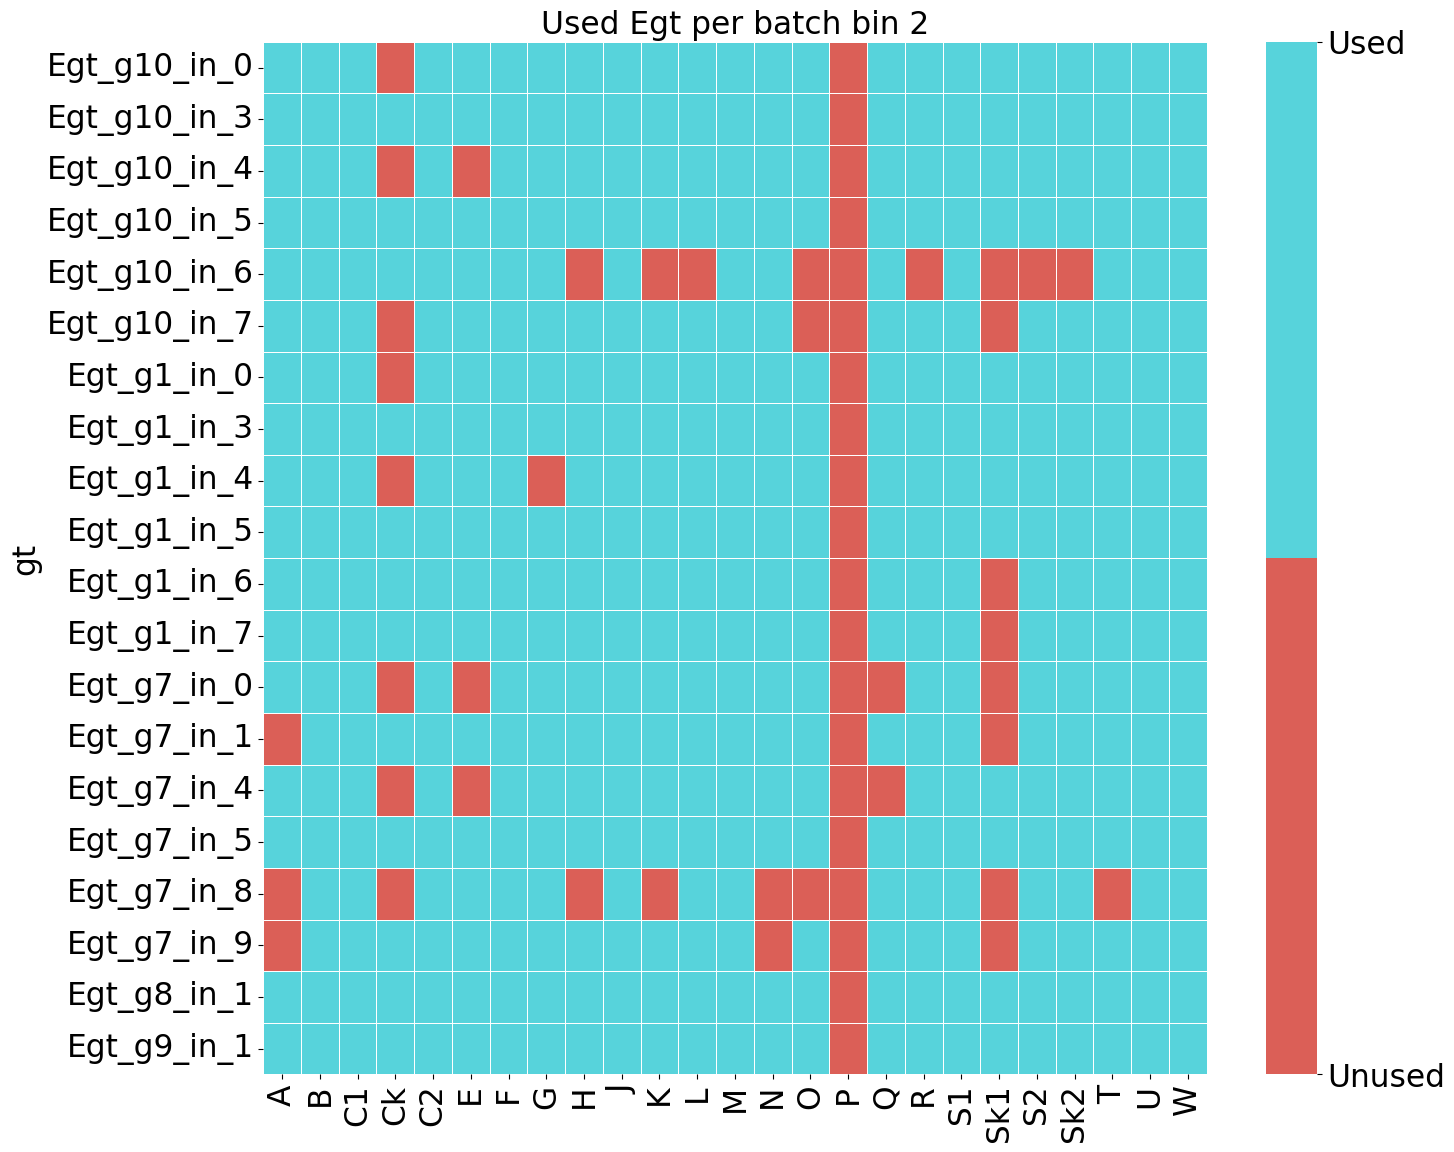

<Figure size 640x480 with 0 Axes>

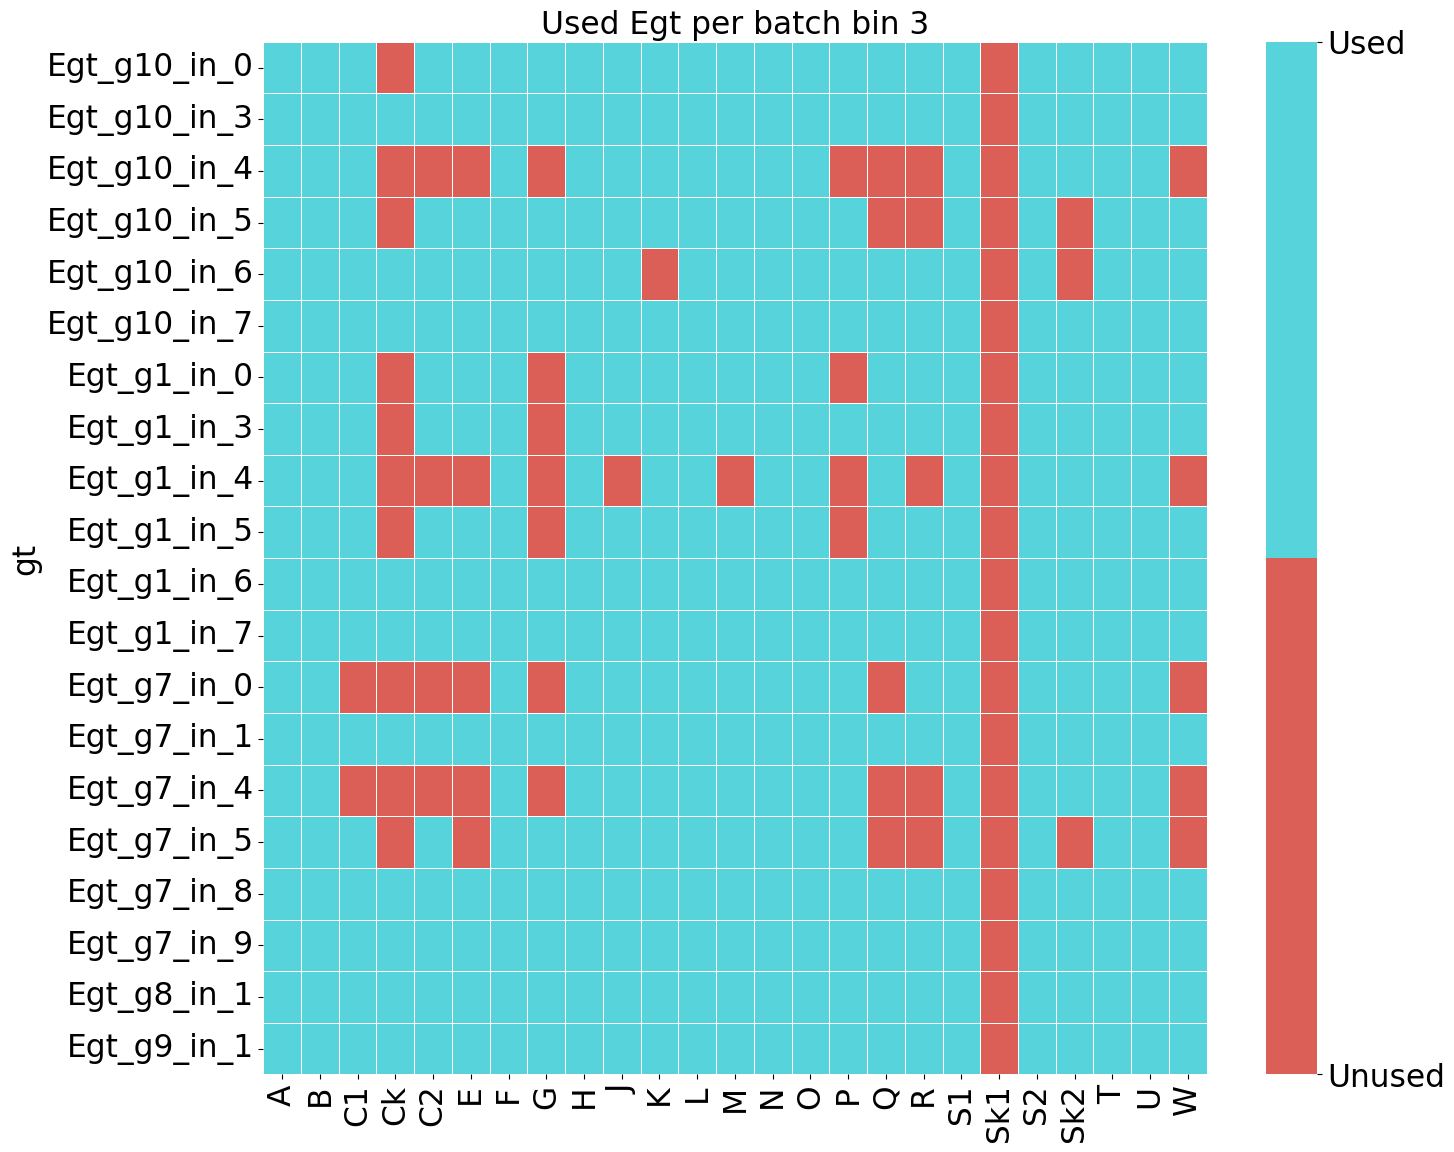

In [39]:
plot_egt_used_per_batch(batches, equations, num_bins, figsize=(15, 12))

Now when we have the results we can save them on the disk for further calculation

In [ ]:
for i in range(1, num_bins + 1):
    batches_prediction.loc[
        batches_prediction.bin == i, "min_umis_depth"
    ] = bins_threshold_list[i - 1]
    batches_prediction.loc[
        batches_prediction.bin == i, "max_umis_depth"
    ] = bins_threshold_list[i]

batches_prediction.index.name = "batch"
batches_prediction.to_csv(
    os.path.join(output_path, "batches_alpha_prediction.csv"), index="batch"
)

## Correcting the metacell model based on the noise estimation

The last part of the process should be correction of the metacell model. 

The first step is to re-create the metacell model with noise estimation data, this will change the cell-cell distances which in turn determine the derivation of metacells. In general, this allow for re-mixing of the cells by removing the effects of the batches those cells originated from. To read more about the different parameters of the metacell model, please see the metacell package.

The first step doesn't change the umis count of the cells or the umi count of the metacells. To actually remove those noisy umis we will do the second step. This step remove umis which are likely generated from the noise. This is being done only in the metacell level.

In [ ]:
batches_prediction = pd.read_csv(
    os.path.join(output_path, "batches_alpha_prediction.csv"), index_col="batch"
)
mat_ad = ad.read_h5ad(mat_clean_path)

### Running both steps 

In [41]:
mat_ad, metacells_ad, batch_empty_droplets = filter_on_common_genes(
    mat_ad, metacells_ad, batch_empty_droplets
)

mat_clean_df = mc.ut.get_vo_frame(mat_ad)
metacell_df = mc.ut.get_vo_frame(metacells_ad)

mat_ad = add_batches_names(mat_ad)
cells_total_umis_count = pd.Series(
    data=mc.ut.get_o_numpy(mat_ad, name="__x__", sum=True), index=mat_clean_df.index
)
mat_ad.obs["umi_depth"] = cells_total_umis_count
mat_ad = add_batch_bin_corrected_umis_information(mat_ad, batches_prediction)
empty_droplets_dist_per_cell_df = get_empty_droplets_dist_per_cell(
    mat_ad, batch_empty_droplets
)
correct_ambient_noise_in_pile = correct_ambient_noise_in_pile_wrapper(
    empty_droplets_dist_per_cell_df
)

Trying to set attribute `.obs` of view, copying.


In [ ]:
# The first step - recreating the metacell model
mc.pl.divide_and_conquer_pipeline(
    mat_ad,
    forbidden_gene_names=mat_ad.var[mat_ad.var.forbidden_gene].index,
    target_metacell_size=320000,
    random_seed=123456,
    feature_correction=correct_ambient_noise_in_pile,
)

remix_mc = mc.pl.collect_metacells(mat_ad, name="remix_mc")

In [ ]:
# the second step - getting denoise metacell
denoise_mc_ad = get_denoise_metacell_ad(
    mat_ad, remix_mc, batches_prediction, batch_empty_droplets
)

In [ ]:
# saving the model
mat_ad.write_h5ad(os.path.join(output_path, "denoise_cells.h5ad"))
denoise_mc_ad.write_h5ad(os.path.join(output_path, "denoise_mc.h5ad"))

### Running only the second step

Although we advise to run both steps, it is possible to only run the second step - removing the noise, from an existing 
metacell model without generating a new model.

In [ ]:
denoise_mc_ad = get_denoise_metacell_ad(
    mat_ad, metacells_ad, batches_prediction, batch_empty_droplets
)

In [ ]:
# saving the new model
denoise_mc_ad.write_h5ad(os.path.join(output_path, "denoise_mc.h5ad"))